# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, one might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture.

In this project, an image classifier is trained to recognize different species of flowers. One can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we'd train this classifier, then export it for use in our application. [This dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories will be used for training & testing, and we can see a few examples below. 

<img src='assets\Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on preprocessed dataset
* Use the trained classifier to predict image content

Following blocks show a step-by-step implementation of the process.

First up is importing the packages we'll need. It's good practice to keep all imports at the beginning of the code.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

import helper

#cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise it can be [downloaded from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_valid_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform = test_valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform = test_valid_transforms)

# Using the image datasets and the transforms, define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

tensor(45)
tensor(0)
tensor(0)


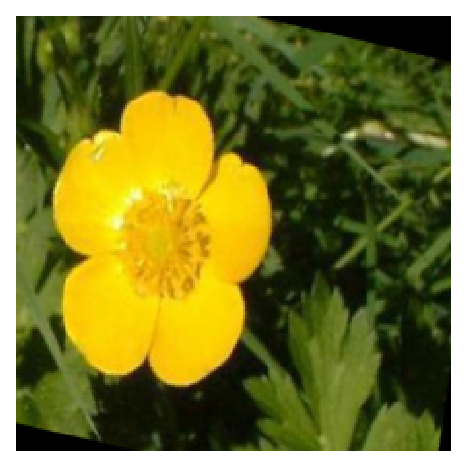

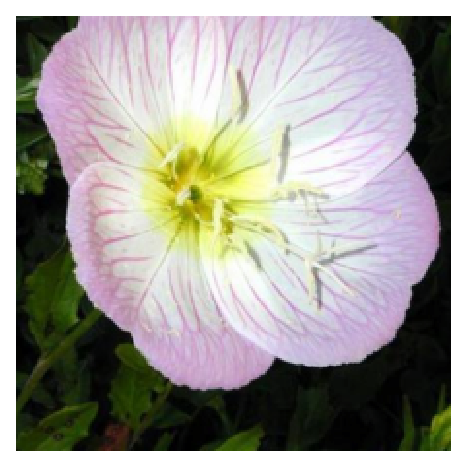

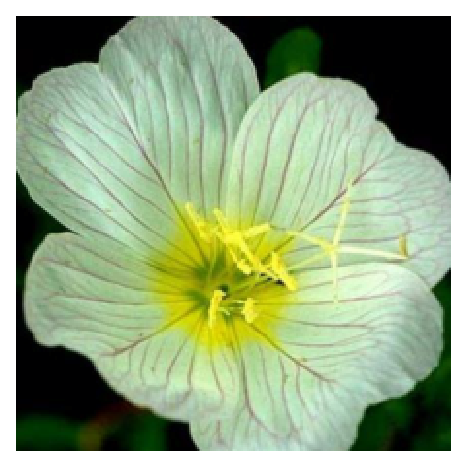

In [4]:
# Run this to test your data loader
train_images, train_labels = next(iter(train_dataloader))
print(train_labels[0])
helper.imshow(train_images[0])
test_images, test_labels = next(iter(test_dataloader))
print(test_labels[0])
helper.imshow(test_images[0])
valid_images, valid_labels = next(iter(valid_dataloader))
print(valid_labels[0])
helper.imshow(valid_images[0])
# print(train_images.size())
# print(test_images.size())
# print(len(test_dataloader))
# print(len(train_dataloader))
# print(len(next(iter(train_dataloader))))

### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print("Flower of catergory 93 : " + str(cat_to_name['93']))

Flower of catergory 93 : ball moss


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. 

Things we'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training we need to make sure only the weights of the feed-forward network are updated.

In [23]:
# Load pretrained vgg19 model
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [24]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('drop1', nn.Dropout(0.3)), 
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu1', nn.ReLU()),
#                           ('drop2', nn.Dropout(0.3)), 
#                           ('fc2', nn.Linear(4000, 200)),
#                           ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [25]:
#Defining criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [26]:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    valid_loss = 0
    steps = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            model.to(device)
            # Validation accuracy
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Validation loss
            steps += 1
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    print("Accuracy of the network on validation images: ", str(100 * correct / total), "%")
    print("Loss of the network on validation images: ", str(valid_loss / steps))

In [27]:
epochs = 3
print_every = 10
steps = 0

# change to cuda
model.to(device)

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(train_dataloader):
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            check_accuracy_on_test(valid_dataloader)
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Running Loss: {:.4f}".format(running_loss/print_every))

            running_loss = 0
            model.train()



Accuracy of the network on validation images:  21.271393643031786 %
Loss of the network on validation images:  3.9431595527208767
Epoch: 1/3...  Running Loss: 7.0511
Accuracy of the network on validation images:  34.10757946210269 %
Loss of the network on validation images:  2.741187476194822
Epoch: 1/3...  Running Loss: 3.6319
Accuracy of the network on validation images:  46.210268948655255 %
Loss of the network on validation images:  2.1472912224439473
Epoch: 1/3...  Running Loss: 2.8292
Accuracy of the network on validation images:  62.836185819070906 %
Loss of the network on validation images:  1.4648198026877184
Epoch: 1/3...  Running Loss: 2.1739
Accuracy of the network on validation images:  64.66992665036675 %
Loss of the network on validation images:  1.3168291065555353
Epoch: 1/3...  Running Loss: 1.8258
Accuracy of the network on validation images:  65.40342298288509 %
Loss of the network on validation images:  1.3221663993138533
Epoch: 1/3...  Running Loss: 1.7898
Accuracy

## Testing the network

It's good practice to test trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. Let's run the test images through the network and measure the accuracy, the same way we did validation.

In [28]:
# Validation on the test set
model.eval()
check_accuracy_on_test(test_dataloader)
model.train()

Accuracy of the network on validation images:  83.51648351648352 %
Loss of the network on validation images:  0.6216285340487957


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Save the checkpoint

Now that the network is trained, let's save the model so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = train_dataset.class_to_idx```

Remember that we'll want to completely rebuild the model later so it can be used for inference. So let's make sure to include any information we need in the checkpoint.

In [29]:
#Save the checkpoint
model.class_to_idx = train_dataset.class_to_idx

trained_model_dict = {'base_model': 'vgg19',
                      'state_dict': model.state_dict(),
                      'classifier': classifier,
                      'class_to_idx': model.class_to_idx,
                      'optimizer_state': optimizer.state_dict,
                      'epochs': epochs}

torch.save(trained_model_dict, 'classifier.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [30]:
#Function that loads a checkpoint and rebuilds the model
def process_checkpoint(chk_pt_path):
    chk_pt = torch.load(chk_pt_path)
    
    base_model = chk_pt['base_model']
    if base_model == 'vgg19':
        model = models.vgg19(pretrained=True)
    else:
        print("Sorry, this checkpoint is for vgg19 only")
    
    #Do not train the features
    for param in model.parameters():
            param.requires_grad = False
    
    #Attach classifier, weights, biases, label indexes to the model
    model.class_to_idx = chk_pt['class_to_idx']
    model.classifier = chk_pt['classifier']
    model.load_state_dict(chk_pt['state_dict'])
    
    return model

In [31]:
#Check if process_checkpoint function works correctly
model = process_checkpoint('classifier.pth')
model.eval()
check_accuracy_on_test(test_dataloader)

Accuracy of the network on validation images:  83.51648351648352 %
Loss of the network on validation images:  0.6216285340487957


# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image.

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

Let's use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, let's resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

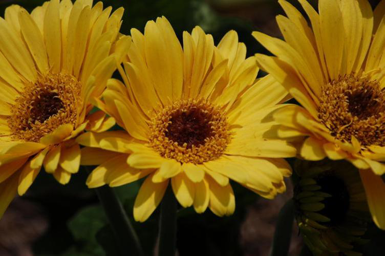

In [32]:
#Test image loading method
image_path = 'flowers/test/41/image_02270.jpg'
img = Image.open(image_path)
img.size
img.thumbnail((666, 256))
img

In [33]:
#Process a PIL image for use in a PyTorch model
def process_image(image_dir):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_dir)
    
    #Resize
    width, height = img.size
    
    if width < height:
        img.thumbnail((256,100000))
    elif width > height:
        img.thumbnail((100000,256))
    else:
        img.thumbnail((256,256))
        
    #Crop
    width, height = img.size

    left = (width-224)/2
    bottom = (height-224)/2
    right = left + 224
    top = bottom + 224
        
    img = img.crop((left, bottom, right, top))
        
    #Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    #Transpose
    img = img.transpose((2, 0, 1))
    
    return img

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [34]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
        
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

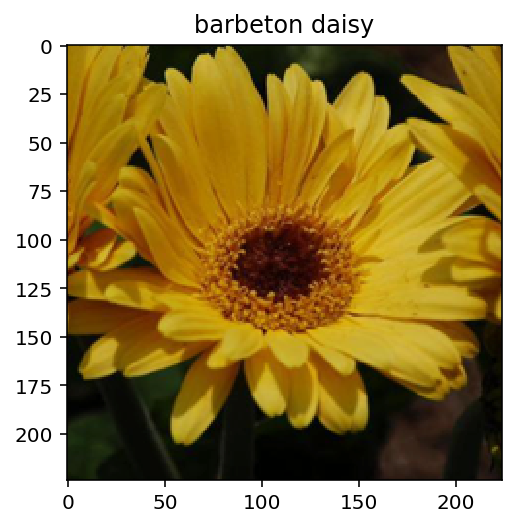

In [35]:
image_path = 'flowers/test/41/image_02270.jpg'
processed_img = process_image(image_path)

#directory number used to convert class to name
imshow(processed_img, title = cat_to_name[image_path.split("/")[2]])

## Class Prediction

Once the images are in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we'll use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx`.

In [36]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Loading the image and converting numpy array to torch float tensor
    img = process_image(image_path)
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Reshape the image fom 3 dimensions to 4, with first dimension as batch size 1
    image_tensor = image_tensor[None]
    image_tensor = image_tensor.to(device)

    # Predictions
    model.eval()
    model.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    ps = torch.exp(output)
    
    # Top k probabilities
    top_ps, top_lab = ps.topk(top_k)
    
    #Tensor to Numpy conversion
    top_ps = top_ps.cpu().numpy().reshape(top_k,)
    top_idx = top_lab.cpu().numpy().reshape(top_k,)
    
    # Invert class_to_idx to idx_to_class
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    # Generate list of top probabiities, labels, and flower names
    prob_list = list(top_ps)
    idx_list = list(top_idx)
    label_list = []
    flower_list = []
    
    for each_idx in idx_list:
        label_list.append(idx_to_class[each_idx])
        flower_list.append(cat_to_name[idx_to_class[each_idx]])
        
    return prob_list, label_list, flower_list

# Implement the code to predict the class from an image file
image_path = 'flowers/test/41/image_02270.jpg'
probs, labels, names = predict(image_path, model)
print(probs, names, labels)

[0.79188102, 0.12517101, 0.079816833, 0.0014273262, 0.00074541778] ['barbeton daisy', 'english marigold', 'sunflower', 'black-eyed susan', 'gazania'] ['41', '5', '54', '63', '71']


## Sanity Checking

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, we'll use the `imshow` function defined above.

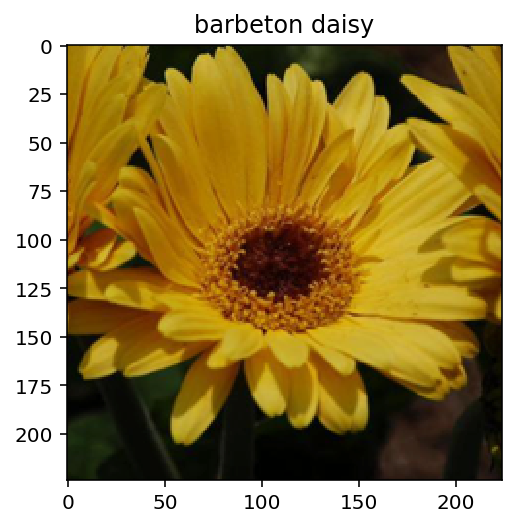

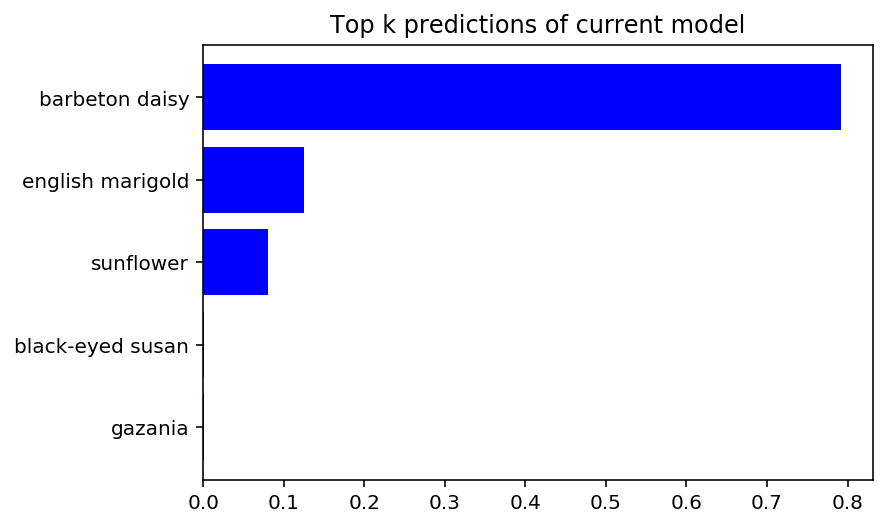

In [37]:
#Display an image along with the top 5 classes

#Run prediction on an input image
image_path = 'flowers/test/41/image_02270.jpg'
top_probs, top_labels, top_flowers = predict(image_path, model)

#display image, directory number used to convert class to name
processed_img = process_image(image_path)
imshow(processed_img, title = cat_to_name[image_path.split("/")[2]])

#bar chart
#plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(top_flowers))

ax.barh(y_pos, top_probs, color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_flowers)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Top k predictions of current model')

plt.show()